# ML- PS3, Juan Arroyo Miranda


In [1]:
%matplotlib inline
%run read_files.py
%run classify
import statsmodels.api as sm
import missingno as msno
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style('whitegrid')

plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 20

# Part 1: Exploratory Data Analysis

This data set is a modified version of data from [Kaggle](https://www.kaggle.com/c/GiveMeSomeCredit).

The objective of this analysis is to predict the probability that somebody will experience financial distress in the next two years.

Our target variable is **SeriousDlquin2yrs** which takes a value of 1 if the person experienced 90 days past due delinquency or worse, and 0 otherwise.

In [2]:
df = read_data('credit-data.csv') 

To better understand our data, we can take a look at different summary statistics for the different features.

We can do this with pandas describe method. However, we have to keep in mind that this method omits missing values, so we'll have to check for that later in our analysis.

In [3]:
df.describe()

,personid,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,zipcode,numberoftime30-59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60-89dayspastduenotworse,numberofdependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,60648.810013,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,56.748197,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,60625.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,60629.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,60644.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,60804.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


There are some interesting things we can learn about our data:

 - Most of the people in our data set have not experienced 90 days past due deliquency.
 
 
 - The average number of dependents is less than 1, but greater than zero (0.76). This suggests that a significant amount of the people in data set have, on average, one dependent.
 
   
 - The average DebtRatio is 333, which means that on average monthly debt (debt payments, alimony,living costs) is 3.33 times bigger than monthy gross income

## Missing Values and Imputation Analysis

In [4]:
process_data.percentage_missing(df)

19.8% missing from: Column monthlyincome
2.6% missing from: Column numberofdependents


#### From our data set only two variables contain missing data: monthly income and number of dependents.

- The percentage of missing values for the number of dependent is very small (2.6% of the data). Our analysis will show that values between 0 and 3 dependents are reasonable for imputation, given the empirical distribution we observe in the data.

- Unfortunately, the percentage of missing data for monthly income is very large, and it is necessary to carefully analyze wheteher the data is missing at random or not.

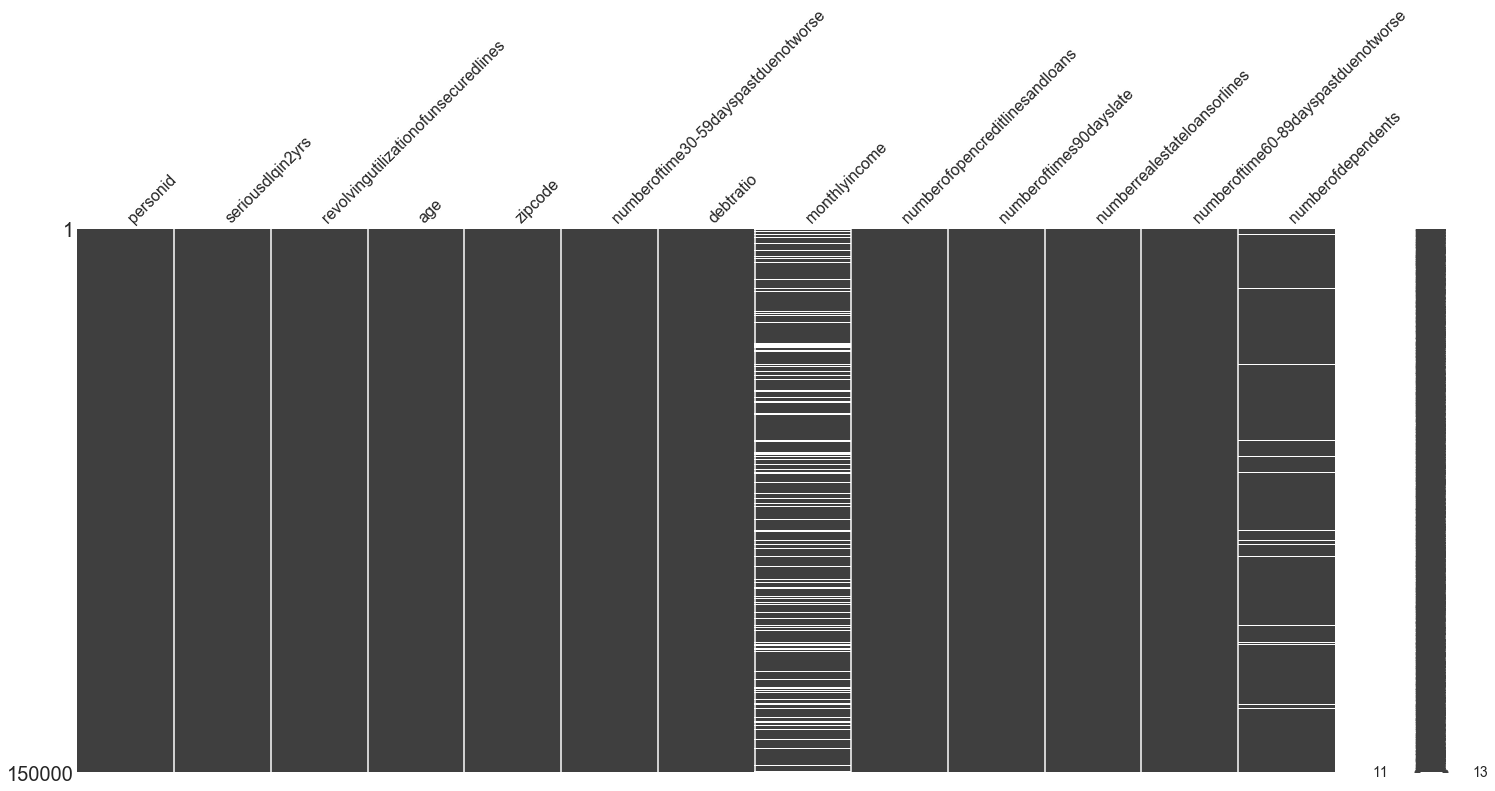

In [5]:
msno.matrix(df)

### Analysis for Number of Dependents

To decide how to impute the data for the number of dependents I created a function that does two things:

- First, it calculates the cumulative sum of the value counts for each possible group in number of dependents.

- Second, it computes the percentage of the observations that fall in each one of these groups.

In [6]:
process_data.des_by_category(df, 'numberofdependents')

,numberofdependents,Cumulative_Sum,Percentage_By_Group
0.0,86902,86902,59.490950
1.0,26316,113218,77.506230
2.0,19522,132740,90.870506
3.0,9483,142223,97.362332
4.0,2862,145085,99.321586
5.0,746,145831,99.832279
6.0,158,145989,99.940442
7.0,51,146040,99.975355
8.0,24,146064,99.991785
9.0,5,146069,99.995208


## Tables are nice, but some visualization is in order

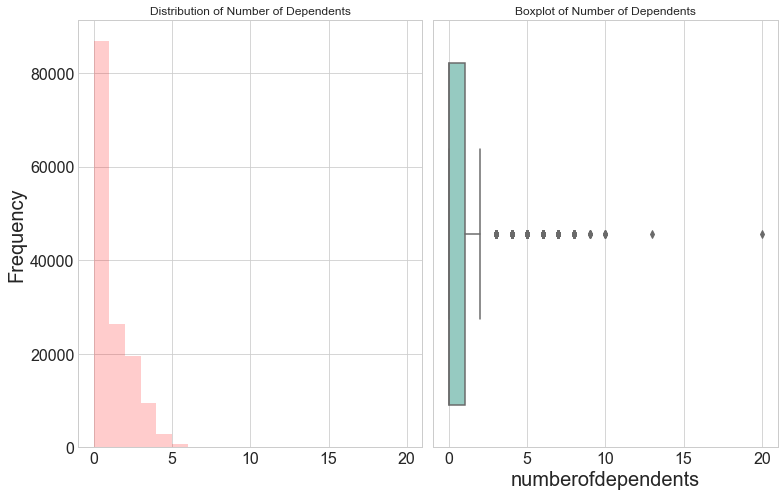

In [7]:
process_data.frequency_plots(df, 'numberofdependents')

The plots show that the distribution of the number of dependents is skewed to the right, with most people
(86,902) having zero dependents. The boxplot shows the presence of some outliers, however, 90.87 % of
the population concentrates between 0 and 2 dependents. Therefore, it would be reasonable to impute
dependents drawn randomly between 0 and 2. While performing this imputation, I will take into account the
frequencies observed in the data for groups 0, 1, and 2.

### Imputation Strategy for number of dependents

From our previous analysis, we know that approximately 91% of the individuals in our data set have between 0 and 2 dependents. We also know the empirical distribution of those dependents.

Based on this, our strategy consists on imputing values between 0 and 2.

Looking at the empirical frequency of values in the data, we will assume that it is representative of the population distribution for number of dependents.

The `impute_val_to_column` in the `process_data.py` module takes care of the imputation for us.

For example, a list containing the following list distribution `[0.65,0.2,0.15]` will draw a zero 65% of the times, a one 20% of the times, and a two 15% of the times.

## Analysis for Monthly Income

One way to determine whether the missing data for the monthly income variable are missing at random is to create a dummy variable that takes the value of 1 if the data is missing (and zero otherwise), and check the correlation with the other features.

A strong correlation with some variable would suggest that the observations are not missing at random.

In [8]:
df["dummy"] = 0
mask = df['monthlyincome'].isnull()
column_name = 'dummy'
df.loc[mask, column_name] = 1

Check that the percentage matches of 1's matches the percentage of 0's

In [9]:
df["dummy"].describe()

count    150000.000000
mean          0.198207
std           0.398650
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: dummy, dtype: float64

In [10]:
X = df.drop(['monthlyincome', 'personid', 'seriousdlqin2yrs'], axis=1)

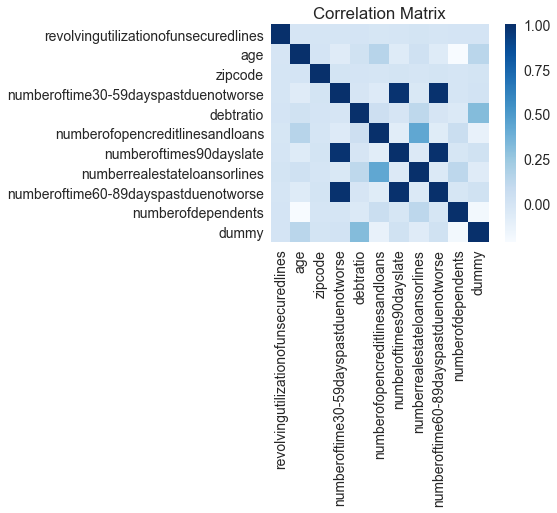

In [11]:
process_data.plot_corr_matrix(X)

Our correlation plot shows the our dummy variable does not seem to be strongly correlated with any of the other features in our data set, with the exception, perhaps, of the debtratio variable.

If there is a statiscally significant difference between the mean of the missing data and the mean of the non-missing data, then we reject the null hypothesis that the mean across groups is the same.

In [12]:
groups = X.drop(["zipcode"], axis = 1).groupby(["dummy"]).mean() # Mean zipcode does not make sense as feature.

In [13]:
groups.T

dummy,0,1
revolvingutilizationofunsecuredlines,5.899873,6.649421
age,51.289792,56.362349
numberoftime30-59dayspastduenotworse,0.381769,0.579866
debtratio,26.598777,1673.396556
numberofopencreditlinesandloans,8.758475,7.216071
numberoftimes90dayslate,0.211925,0.484612
numberrealestateloansorlines,1.054519,0.871481
numberoftime60-89dayspastduenotworse,0.187829,0.452995
numberofdependents,0.851832,0.316310


The table already shows that there is a difference between groups in terms of debtratio, but we still need to provide statistical evidence for this claim.

In [14]:
d = process_data.generate_test_stats(X.drop(["zipcode"], axis = 1), list(X.drop(["zipcode"], axis = 1).columns))

In [15]:
dict_ = process_data.test_means(d)
pd.DataFrame(dict_ ,index = ['p-values']).T

,p-values
age,0.000000e+00
debtratio,0.000000e+00
numberofdependents,0.000000e+00
numberofopencreditlinesandloans,0.000000e+00
numberoftime30-59dayspastduenotworse,2.976618e-13
numberoftime60-89dayspastduenotworse,6.550930e-23
numberoftimes90dayslate,5.535300e-24
numberrealestateloansorlines,2.217983e-138
revolvingutilizationofunsecuredlines,6.431040e-01


### Monthly Income Data is not missing at random!!!

The mean tests for all the covariates in our auxiliary matrix X show that there is a statistically significant difference between the mean of missing and non-missing values.

Therefore, it is important to us an imputation technique that takes into account that monthly income is a function of all other covariates.

### Imputation Strategy


A good way to get a good prediction for missing data is using the **Random Forest Classifier** to predict missing values for monthly income.

The imputation strategy can be seen in the `classify.py` module under`rf_imputation`:

- Train on the subset of the data that has no missing values for monthly income.

- Predict on the subset of the data that corresponds to the missing values.

- Insert the predictions in the corresponding indices in the dataframe.

- This imputation procedure is repeated on our Test set, once we do the Train-Test split.


The reasons for choosing this classifier are the following:

- By creating different trees selecting random subset of features it reduces the variance in our model.

- By averaging the different predicitions, it reduces the bias for our predcition.

#  Part 2: Feature Enginnering

Our original data set contains a mix of continuous and discrete features.

To engineer our features, we will perform at least one of the following transformation:

 - Discretize a continuous variable into different ranges.
 
 - Encode non-ordinal/ordinal numeric variables as dummies.
 
 - Normalize features to control for high variability in the data.
 
 
<u>Examples:</u>

Variables like **zip code** may contain relevant information related to our target variable. However, zip code number has no ordinal interpretation.

In this case, we can better exploit the information in this feature by encoding each zip code as a dummy variable and adding it to our data set.

Features like monthly income or revolving utilization of unsecuredlines, show high variability in the data. To avoid that the presence of outliers 'contaminates' with noise our prediction, we normalized these features.


To increase the number of features in our data set, we decided to discretize the **age** variable by condering the groups of individuals that fall in different 5 year cohorts, i.e., 20-25, 25-30, ..., etc.

As follwing table shows, discretizing age allows us to look at different patterns than before.

Finally, we convert this buckets into dummy variables for the models.

### Discretize: A way to see different patterns

In [16]:
bins_age = range(20,120,5)
discr = df.copy()
age_bucket = process_data.discretize(discr, 'age', bins_age)

Two facts abouts the age buckets:

 - People between 25 and 30 years are more likely to be in serious financial distress. This seems to be consistent with the idea that young people are usually struggling with college debts.
 
 - The highest debt ratio is for the 105-110 group with a 1132 debt to income ratio, followed by the 60-65 group.

In [17]:
d1 = discr[['seriousdlqin2yrs', 'bins_age']].groupby(['bins_age']).mean()
d2 = discr[['debtratio', 'bins_age']].groupby(['bins_age']).mean()
d3 = discr[['monthlyincome', 'bins_age']].groupby(['bins_age']).mean() #Does not include Nan values
pd.concat([d1,d2, d3], axis =1)

,seriousdlqin2yrs,debtratio,monthlyincome
bins_age,,,
"(20, 25]",0.111662,42.920471,1992.730087
"(25, 30]",0.117206,117.821546,3673.554835
"(30, 35]",0.106916,194.727712,5180.510545
"(35, 40]",0.091323,306.427843,6188.330111
"(40, 45]",0.085452,344.803221,7243.002241
"(45, 50]",0.080089,384.760632,7437.940519
"(50, 55]",0.071553,404.127353,7867.948751
"(55, 60]",0.051402,481.970435,7627.215218
"(60, 65]",0.040095,523.597311,7511.872990


# Parts 3: Model Selection and Implementation

### Define target variable and features:

In [18]:
y = df['seriousdlqin2yrs']
X = df.drop(['seriousdlqin2yrs'], axis=1)

###  Which Classifiers ?

Since we are dealing with the prediction of a binary outcome, our task is to predict correctly the target label (0 or 1).

We can think about this problem as prediciting the probability of belonging to one class or the other.

The task of the classifier can be summarized in two steps:

- Classify our predictions, $ y^{*} = f(\mathrm{x}; \mathrm{w}^{*})$, based on a **decision rule**:

\begin{equation} 
  y^{*} = 
 \begin{cases}  1 \quad \text{if} \quad f(\mathrm{x}; \mathrm{w}^{*}) \ge threshold\\
 0 \quad \text{otherwise} 
 \end{cases}
 \end{equation}

- Separate the space into two \half-spaces" through a decision boundary

Some common choices to deal with this type of classification problem are:

- Logistic Regression

- Decision Trees

- Random Forests

- Naive Bayes 
    - (Commonly used as a benchmark to compare the performance of all other classifiers.)

- Support Vector Machines

# Define models


In [21]:
models_to_run=['LR','DT','RF','NB','LSVC']

### Justify Hyperparameter Selection

### Define Hyperparameters

In [22]:
    small_grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,10], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.001,0.1,1,10,100,1000,10000]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [5,10,14], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'LSVC' :{'penalty': ['l1','l2'], 'C' :[0.001,0.01,0.1,1,10]},
    'NB':{}
           }

### Results Data Frame

The `do_learning` function runs every model in the hyperparameter grid defined above. The function implements a modified version of [Rayid Ghani](https://github.com/rayidghani/magicloops/blob/master/magicloop.py).

Since we are looking for the best possible prediction, it is important to do a search of hyperparameter space.

The search described above is far from exhaustive, but it serves as an example of type of work that is necessary in the model selection stage.

In [23]:
results, matrix = do_learning(models_to_run, 'small', X, y)

LR
DT
RF
NB
LSVC


### Sort Results by Metric of Choice: Area Under the ROC Curve (AUC)

In [34]:
sorted_results = results.sort_values('auc-roc', ascending=False)
sorted_results = sorted_results[['model_type', 'parameters','train_time','predict_time','auc-roc']]

In [35]:
sorted_results.head()

,model_type,parameters,train_time,predict_time,auc-roc
57,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1.601041,1.721840,0.815303
61,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",1.404270,1.518333,0.812702
59,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1.621044,1.711015,0.810025
58,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.228515,0.337727,0.808793
56,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.227345,0.340179,0.806110


The Random Forest classifier performs better than the Naive Bayes classifier, which produces a correct classification 50% of the times.

In [36]:
sorted_results[sorted_results["model_type"] =="NB"]

,model_type,parameters,train_time,predict_time,auc-roc
72,NB,{},0.063729,0.07908,0.5


In [26]:
index = sorted_results.head(1).index.values

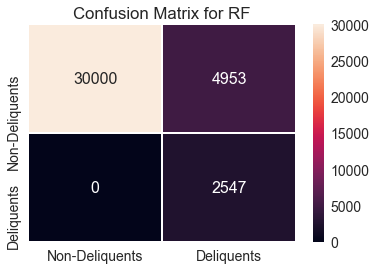

In [27]:
plot_confusion_matrix(matrix[index[0]]['matrix'], ['Non-Deliquents', 'Deliquents'], matrix[index[0]]['title'])

## Summary of Results

The Random Forests classifier outperformed Logistic Regression and Decision Trees on the Validation set.

The accuracy for the best model on the validation set was 82.7%, which means that, on average, our predictions will be correct 82.7% of the times.

Nevertheless, we will make mistakes. As the confusion matrix shows, the classifier is very good at predicting non-deliquents, but not so good at predicting deliquents.


This makes sense when we consider that most of the observations in our data set are non-deliquents. Since the validation set is a random sample of this data, the distribution of non-deliquents should be similar to the one in the training set.

From a business perspective, the biggest problem is not able to classify deliquents correctly.

Currently, our misclassification rate is: $\displaystyle \frac{4953}{4953 + 2547} = 0.66$, which is a huge number!!

Room for improvement:

- Change the classification threshold (currently 0.5)

- Increase parameter space

- Consult domain experts for feature engineering